In [1]:
import cv2 as cv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
bd_configPath = 'models/bib_detector/RBNR2_custom-yolov4-tiny-detector.cfg'
bd_weightsPath = 'models/bib_detector/RBNR2_custom-yolov4-tiny-detector_best.weights'
bd_classes = ['bib']

In [3]:
class Detector:
    """
    Create YOLO object detection model in OpenCV with a given config and weights.
    Use this model to make predictions.
    
    Attributes
        classes (list): list of class names
        net (obj): openCV network object
        ln (obj): openCV layer names object
    """
    
    def __init__(self, cfg, wts, classes):
        """Initialize detector object
        
        Args
            cfg (str): path to model config file
            wts (str): path to model weights file
            classes (list): list of class names
        """
        
        self.classes = classes
        self.net = cv.dnn.readNetFromDarknet(cfg, wts)
        self.net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)

        # determine the output layer
        self.ln = self.net.getLayerNames()
        self.ln = [self.ln[i - 1] for i in self.net.getUnconnectedOutLayers()]
        
    def detect(self, img, conf, swapRB=True):
        """
        Make predictions and return classes and bounding boxes
        
        Args
            img (numpy array): image array from openCV .imread
            conf (float): prediction confidence threshold
            
        Returns
            List containing bounding box values and class names for detections
            in the form [<class name>, [x, y, width, height]]
        """
        
        #format image for detection
        blob = cv.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=swapRB, crop=False)
        
         # get detections
        self.net.setInput(blob)
        outputs = self.net.forward(self.ln)
        
        # initialize lists
        boxes = []
        confidences = []
        classIDs = []

        # initialize image dimensions
        h_img, w_img = img.shape[:2]

        for output in outputs:
            for detection in output:
                scores = detection[5:]
                classID = np.argmax(scores)
                confidence = scores[classID]

                # drop low confidence detections and 
                if confidence > conf:
                    box = detection[:4] * np.array([w_img, h_img, w_img, h_img])
                    (centerX, centerY, width, height) = box.astype("int")
                    x = int(centerX - (width / 2))
                    y = int(centerY - (height / 2))
                    box = [x, y, int(width), int(height)]
                    boxes.append(box)
                    confidences.append(float(confidence))
                    classIDs.append(classID)

        # apply non maximal suppression for
        # initialize lists
        self.boxes = []
        self.confidences = []
        self.detected_classes = []
        cls_and_box = []
        # get indices of final bounding boxes  
        indices = cv.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

        if len(indices) > 0:
            for i in indices.flatten():
                self.boxes.append(boxes[i])
                self.confidences.append(confidences[i])
                self.detected_classes.append(self.classes[classIDs[i]])
                
                cls_and_box.append([self.classes[classIDs[i]], boxes[i]])
        
        return cls_and_box


In [4]:
def crop(img, bib_detections):
    if len(bib_detections) > 0:
        for obj in bib_detections:
            (x, y, w, h) = obj[1]
    return img[y:y+h, x:x+w]

In [5]:
bd = Detector(bd_configPath, bd_weightsPath, bd_classes)

In [11]:
path_to_file = "/Users/arpitsharma/Downloads/hell_race/40161775_1429457957185386_5440678869071822848_o.jpg"
# img = cv.cvtColor(cv.imread(path_to_file), cv.COLOR_BGR2RGB)
img = cv.imread(path_to_file)

In [12]:
bib_detections = bd.detect(img, 0.25, swapRB=True)
bib_detections

[['bib', [421, 1564, 303, 124]]]

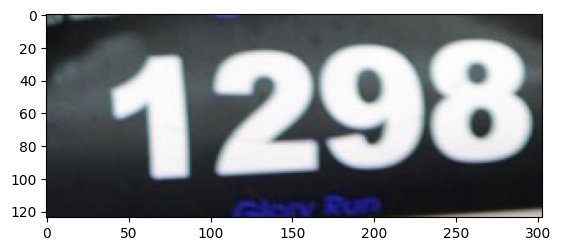

In [13]:
plt.imshow(crop(img, bib_detections))

In [14]:
bib_detections = bd.detect(img, 0.25, swapRB=False)
bib_detections

[['bib', [390, 1555, 345, 140]]]

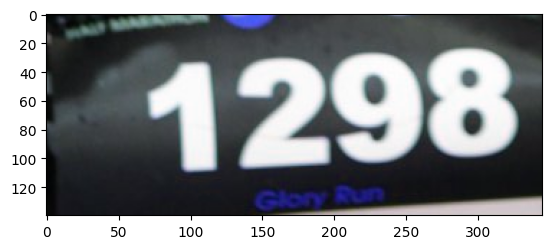

In [15]:
plt.imshow(crop(img, bib_detections))